### High quantities of semaglutide

Semaglutide is a new glucagon-like peptide-1 (GLP-1) agonist, used to treat diabetes. Both semaglutide and duaglutide (a similar GLP-1 agonist) are used weekly.  However, while both drugs come in disposable pen injectors,duaglutide is a single use injector i.e. you need one box of four pens for a month, whereas each semaglutide pen has four doses, i.e. one pen will last a month.

We have heard reports that prescribers are prescribing higher quantities of semaglutide than expected, with a number of prescriptions being for 4 pens, i.e 4 months supply, _not one month_. This note book sets out to check: 
a) are prescribers prescribing excess semaglutide due to confusion related to 4 doses being in one pen
b) are EHRs having an effect based on the way the information is presented to prescribers. 

In [2]:
##importing libraries
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [30]:
sql = '''
SELECT
  CAST(month AS DATE) AS month,
  pct,
  SUM(CASE
      WHEN quantity_per_item>=4 THEN items
      ELSE 0
  END) AS items_four,
  SUM(CASE
      WHEN MOD(quantity_per_item,4)=0 THEN items
      ELSE 0
  END) AS mod_4_items,
  SUM(items) AS total_items,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item>=4 THEN items
      ELSE 0
  END),
      SUM(items)) AS percent_items_four,
  IEEE_DIVIDE(SUM(CASE
      WHEN MOD(quantity_per_item,4)=0 THEN items
      ELSE 0
  END),
      SUM(items)) AS percent_mod_four,    
  SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END) AS quantity_four,
  SUM(total_quantity) AS total_quantity,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_quantity_four
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
hscic.ccgs AS ccgs
ON
presc.pct=ccgs.code
WHERE
(bnf_code LIKE "0601023AW%") ##semaglutide
AND
ccgs.org_type='CCG'
GROUP BY
  month,
  pct
    '''

df = bq.cached_read(sql, csv_path='df_sema_qty.csv')
df['month'] = df['month'].astype('datetime64[ns]')
df.head()

,month,pct,items_four,mod_4_items,total_items,percent_items_four,percent_mod_four,quantity_four,total_quantity,percent_quantity_four
0,2019-02-01,00D,0,0,2,0.000000,0.000000,0,4,0.000000
1,2019-02-01,00T,1,1,12,0.083333,0.083333,4,17,0.235294
2,2019-02-01,00V,0,0,4,0.000000,0.000000,0,4,0.000000
3,2019-02-01,01D,0,0,1,0.000000,0.000000,0,1,0.000000
4,2019-02-01,01W,1,1,12,0.083333,0.083333,4,15,0.266667


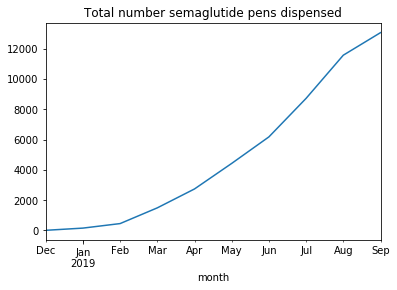

In [27]:
df.groupby("month")['total_quantity'].sum().plot(kind='line', title="Total number semaglutide pens dispensed")

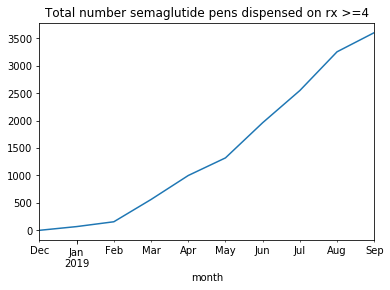

In [28]:
df.groupby("month")['quantity_four'].sum().plot(kind='line', title="Total number semaglutide pens dispensed on rx >=4")

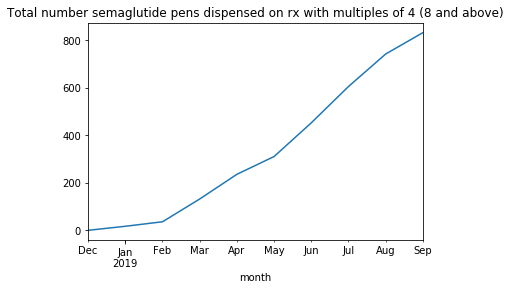

In [29]:
df.groupby("month")['mod_4_items'].sum().plot(kind='line', title="Total number semaglutide pens dispensed on rx with multiples of 4 (8 and above)")

Assuming that there were 3,500 pens prescribed erroneously as a quantity of 4 or greater in September 2019, this would suggest an excess cost of nearly £200,000 per month (3500 x 73.25 x 0.75 = £192,281.25)

In [14]:
sql = '''
SELECT
  DATE(month) AS month,
  quantity_per_item,
  SUM(items) as items
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
WHERE
bnf_code LIKE "0601023AW%" --semaglutide
GROUP BY
  month,
  quantity_per_item
    '''
quan_df = bq.cached_read(sql, csv_path='df_sema_qty_item.csv')
quan_df['month'] = quan_df['month'].astype('datetime64[ns]')

In [15]:
quan_df.head()

,month,quantity_per_item,items
0,2019-08-01,2,461
1,2019-08-01,13,1
2,2019-08-01,28,1
3,2019-09-01,1,8201
4,2019-09-01,4,802


In [16]:
quan_df.pivot(index='month', columns='quantity_per_item', values='items')

quantity_per_item,1,2,3,4,5,6,7,8,10,11,12,13,16,28
month,,,,,,,,,,,,,,
2018-12-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,94.0,1.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,280.0,11.0,1.0,35.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,865.0,27.0,7.0,129.0,2.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,1587.0,70.0,11.0,232.0,4.0,NaN,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN
2019-05-01,2813.0,132.0,19.0,305.0,4.0,2.0,NaN,7.0,NaN,NaN,2.0,NaN,NaN,NaN
2019-06-01,3745.0,214.0,28.0,438.0,3.0,7.0,1.0,18.0,NaN,NaN,NaN,1.0,NaN,NaN
2019-07-01,5452.0,325.0,43.0,600.0,7.0,4.0,NaN,11.0,NaN,NaN,1.0,1.0,NaN,NaN
2019-08-01,7330.0,461.0,40.0,721.0,13.0,6.0,NaN,22.0,4.0,NaN,2.0,1.0,NaN,1.0


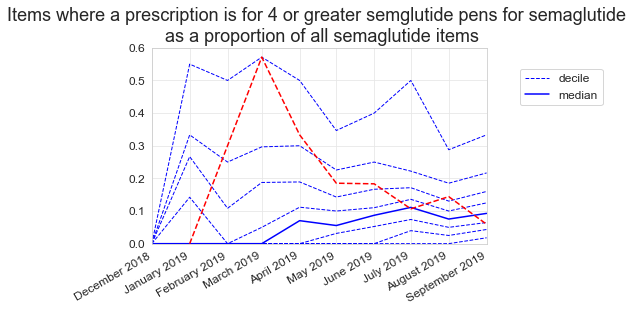

In [16]:
##here we chart a measure of semaglutide quantity of 4

charts.deciles_chart(
        df,
        period_column='month',
        column='percent_items_four',
        title="Items where a prescription is for 4 or greater semglutide pens for semaglutide \n as a proportion of all semaglutide items",
        show_outer_percentiles=False)

#add in example CCG (Devon - 15N)
df_subject = df.loc[df['pct'] == '15N'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_items_four'], 'r--')

plt.show()

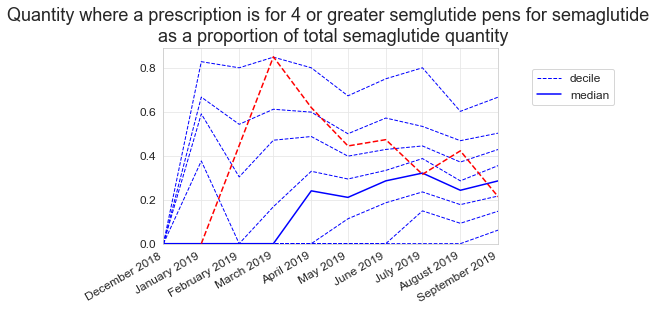

In [17]:
##here we chart a measure of semaglutide quantity of 4

charts.deciles_chart(
        df,
        period_column='month',
        column='percent_quantity_four',
        title="Quantity where a prescription is for 4 or greater semglutide pens for semaglutide \n as a proportion of total semaglutide quantity",
        show_outer_percentiles=False)

#add in example CCG (Devon - 15N)
df_subject = df.loc[df['pct'] == '15N'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_quantity_four'], 'r--')

plt.show()

In [ ]:
##here we chart a measure of semaglutide quantity where multiple of 4 and greater than 4

charts.deciles_chart(
        df,
        period_column='month',
        column='percent_items_four',
        title="Items where a prescription is for 4 or greater semglutide pens for semaglutide \n as a proportion of all semaglutide items",
        show_outer_percentiles=False)

#add in example CCG (Devon - 15N)
df_subject = df.loc[df['pct'] == '15N'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_items_four'], 'r--')

plt.show()

### EHR

In [6]:
sql = """
SELECT
rx.month,
TRIM(Principal_Supplier) AS supplier,
    SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END) AS four,
  SUM(total_quantity) AS total_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_four
FROM
ebmdatalab.hscic.raw_prescribing_normalised AS rx
JOIN
  alex.vendors AS software
ON
  software.ODS = rx.practice
  AND date(software.Date) = date(rx.month)
WHERE
bnf_code LIKE "0601023AW%" ##semglutide
GROUP BY
rx.month,
supplier
ORDER BY
month"""

df_ehr_sema = bq.cached_read(sql, csv_path='df_ehr_sema.csv')
df_ehr_sema['month'] = df_ehr_sema['month'].astype('datetime64[ns]')
df_ehr_sema.head(3)

,month,supplier,four,total_QI,percent_four
0,2018-12-01,EMIS,0,2,0.000000
1,2019-01-01,TPP,28,48,0.583333
2,2019-01-01,EMIS,32,77,0.415584


Text(0.5, 1.0, 'total semaglutide pens per EHR vendor')

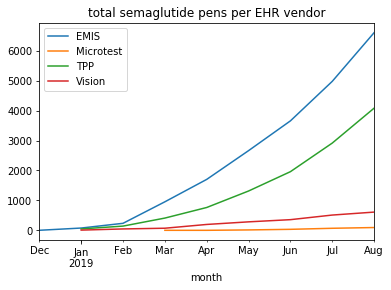

In [7]:
df_ehr_sema.groupby(['month', 'supplier']).sum()['total_QI'].unstack().plot.line()
plt.legend(loc='best')
plt.title("total semaglutide pens per EHR vendor")

Text(0.5, 1.0, 'Total quantity where a prescription is for 4 or greater semaglutide pens for semaglutide \n as a proportion of all semaglutide pens dispensed')

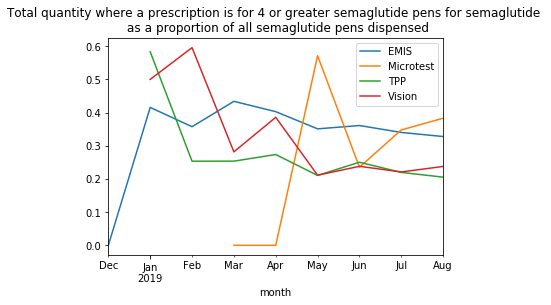

In [9]:
df_ehr_sema.groupby(['month', 'supplier']).sum()['percent_four'].unstack().plot.line()
plt.legend(loc='best')
plt.title("Total quantity where a prescription is for 4 or greater semaglutide pens for semaglutide \n as a proportion of all semaglutide pens dispensed")

This numbers are probably too low to detect anything meaningful however we should revisit questions like this if we obtain funding to do substantial work on EHR design.

### Conclusion

There are a relatively high number of prescriptions for high quantities of semaglutide, which suggests that prescribers may be unsure of the correct number to prescribe. We should create an measure to alert practices that are routinely prescribing high quantities.  We should also create a blog describing the issue